In [122]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import torch
from PIL import Image
from sklearn.utils import shuffle
import glob
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import numpy as np
import random
from tqdm import tqdm
import torchvision
import pickle
import cv2
import numpy as np
from matplotlib import pyplot as plt
from torch import nn
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
import torch.optim as optim
import argparse
import time


In [123]:
#set which device to use - cpu/gpu

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [124]:
vehicleFolder = 'online/samples/vehicles/'
nonVehiclesFolder = 'online/samples/non-vehicles/'

vehicles = glob.glob('{}**/*.png'.format(vehicleFolder), recursive=True)
nonvehicles = glob.glob('{}**/*.png'.format(nonVehiclesFolder), recursive=True)


In [125]:
count_vehicles = len(vehicles)
count_nonvehicles = len(nonvehicles)
convert_tensor = transforms.ToTensor()
merged_data = []

selection_vehicles = random.sample(range(0,count_vehicles), k = min(count_vehicles,count_nonvehicles))
selection_nonvehicles = random.sample(range(0,count_nonvehicles), k = min(count_vehicles,count_nonvehicles))

for i in selection_vehicles:
    img = Image.open(vehicles[i])
    trial = convert_tensor(img)
    mean, std = trial.mean([1,2]), trial.std([1,2])
    transform_norm = transforms.Compose([transforms.Normalize(mean, std)])

    # get normalized image
    img_n = transform_norm(trial)
    merged_data.append((img_n,1))
    
for i in selection_nonvehicles:
    img = Image.open(nonvehicles[i])
    trial = convert_tensor(img)
    mean, std = trial.mean([1,2]), trial.std([1,2])
    transform_norm = transforms.Compose([transforms.Normalize(mean, std)])

    # get normalized image
    try:
        img_n = transform_norm(trial)
    except:
        print(i)
        continue
    merged_data.append((img_n,0))

merged_data = shuffle(merged_data)    


2901


In [126]:
len(merged_data)

11931

In [127]:
#Train-Test Split
test_data = []
train_data = []
data_size = len(merged_data)
selection_train = list(range(0,data_size))
selection_test = random.sample(range(0,data_size), k = int(0.2*data_size))

for i in selection_test:
    selection_train.remove(i)
    test_data.append(merged_data[i])

for i in selection_train:
    train_data.append(merged_data[i])
    
#Create data loaders
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [128]:
#Model definition

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = (3,3), stride=1, padding='same'),
            nn.ReLU()
        )
        
        self.dropout1 = nn.Sequential(
            nn.Dropout(0.5)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), stride=1, padding='same'),
            nn.ReLU()
        )
        
        self.dropout2 = nn.Sequential(
            nn.Dropout(0.5)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3,3), stride=1, padding='same'),
            nn.ReLU()
        )
        
        self.maxpool1 = nn.Sequential(
            nn.MaxPool2d(kernel_size = (8,8))
        )
        
        self.dropout3 = nn.Sequential(
            nn.Dropout(0.5)
        )
        
        self.fcl = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 1, kernel_size = (8,8)),
            nn.Sigmoid()
        )
        
        

    def forward(self, x):
        #print(x.shape)
        x = self.dropout1(self.layer1(x))
        #print(x.shape)
        x = self.dropout2(self.layer2(x))
        #print(x.shape)
        x = self.dropout3(self.maxpool1(self.layer3(x)))
        #print(x.shape)
        x = self.fcl(x)
        #print(x.shape)
        
        return x

In [129]:
model = NeuralNetwork().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [130]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        
        X, y = X.to(device), y.to(device)
        y = y.type(torch.float32)
        # Compute prediction error
        pred = model(X)
        
        pred = torch.reshape(pred, (len(y),))
        
        #print(pred.shape)
        loss = loss_fn(pred, y)
        
    
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    

In [131]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            pred = torch.reshape(pred, (len(y),))
            
            test_loss += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            for (i,j) in zip(pred,y):
                if i>0.5:
                    i=1
                else:
                    i=0
                if i==j:
                    correct+=1
        
        
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*correct, test_loss

In [ ]:
epochs = 10
train_acc = []
test_acc = []
train_loss = []
max_test_acc = 0

for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)

    #test acc
    cur_test_acc, cur_test_loss = test(test_dataloader, model, loss_fn)
    test_acc.append(cur_test_acc)
    if cur_test_acc > max_test_acc:
        max_test_acc = cur_test_acc
        torch.save(model.state_dict(), 'best-vehicle-parameters.pt')

    #train acc
    cur_train_acc, cur_train_loss = test(train_dataloader, model, loss_fn)
    train_acc.append(cur_train_acc)
    train_loss.append(cur_train_loss)
print("Done!")

In [132]:
#load best vehicle model parameters
model = NeuralNetwork()
model.load_state_dict(torch.load('best-vehicle-parameters.pt'))
model.eval()

NeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (dropout1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (dropout2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (maxpool1): Sequential(
    (0): MaxPool2d(kernel_size=(8, 8), stride=(8, 8), padding=0, dilation=1, ceil_mode=False)
  )
  (dropout3): Sequential(
    (0): Dropout(p=0.5, inplace=False)
  )
  (fcl): Sequential(
    (0): Conv2d(64, 1, kernel_size=(8, 8), stride=(1, 1))
    (1): Sigmoid()
  )
)

In [133]:
#test accuracy of vehicle detection model
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 99.7%, Avg loss: 0.003228 



(99.66471081307627, 0.003227956814347029)

In [134]:
#load best pedestrian model parameters
modelped = NeuralNetwork()
modelped.load_state_dict(torch.load('best_pedestrian_model.pt'))
modelped.eval()

NeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (dropout1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (dropout2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (maxpool1): Sequential(
    (0): MaxPool2d(kernel_size=(8, 8), stride=(8, 8), padding=0, dilation=1, ceil_mode=False)
  )
  (dropout3): Sequential(
    (0): Dropout(p=0.5, inplace=False)
  )
  (fcl): Sequential(
    (0): Conv2d(64, 1, kernel_size=(8, 8), stride=(1, 1))
    (1): Sigmoid()
  )
)

In [135]:
#TESTING THE models on a large image that could be from an on-board camera of a vehicle

Input image with dimensions [3, 64, 64] :


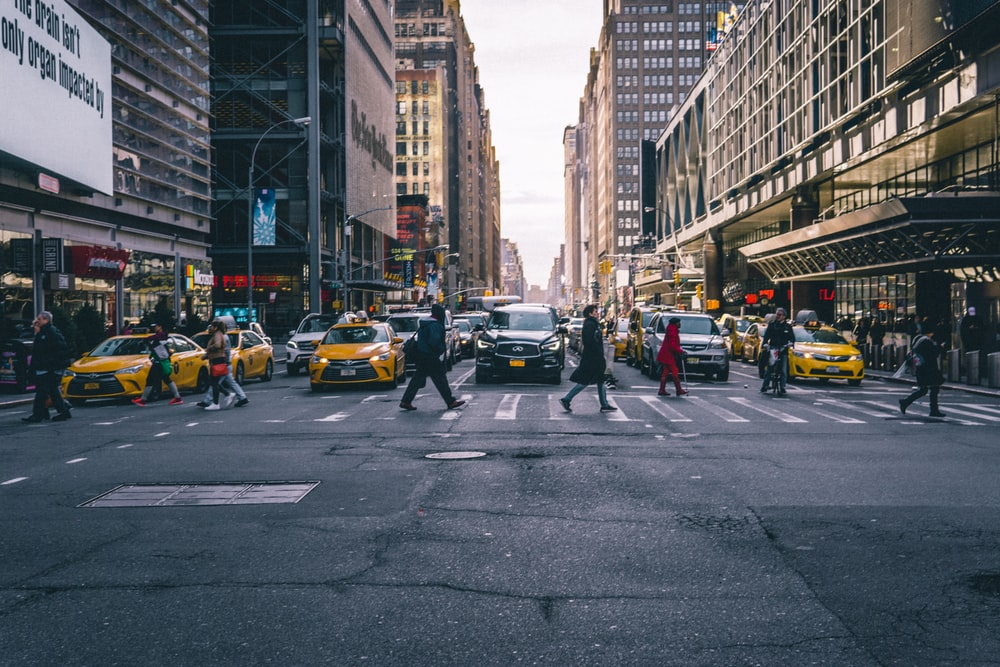

Normalized Image


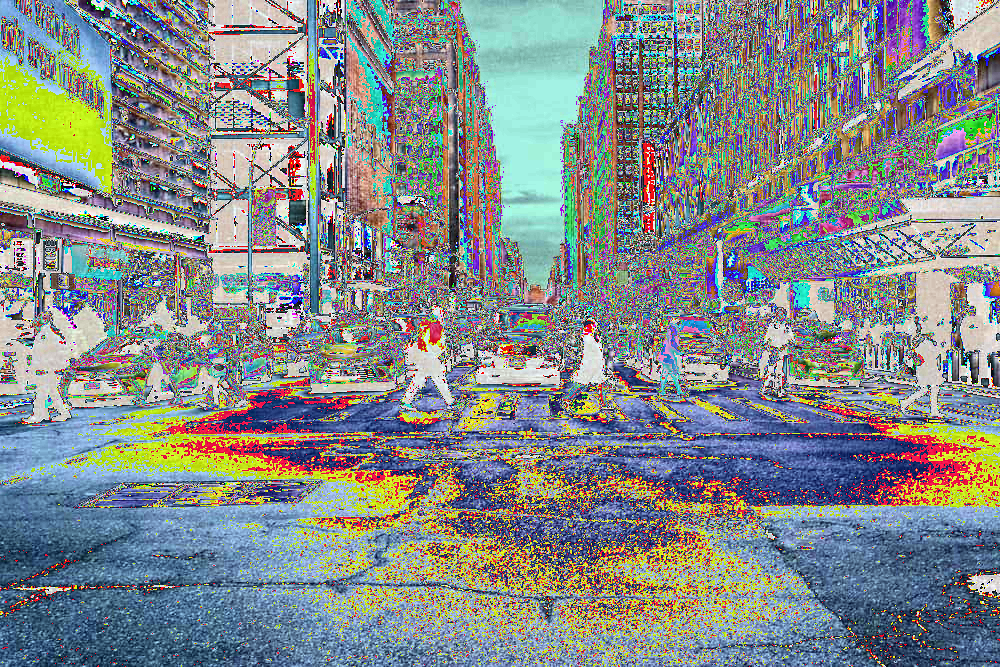

In [136]:
file_name = 'd3.jpg'
topil = transforms.ToPILImage()
img = Image.open(file_name)
print("Input image with dimensions",list(img_n.shape),":")

display(img)
trial = convert_tensor(img)
trial = trial[:3]
mean, std = trial.mean([1,2]), trial.std([1,2])

transform_norm = transforms.Compose([transforms.Normalize(mean, std)])

# get normalized image
img_n = transform_norm(trial)

#print(img_n.shape)
img = topil(img_n)
print("Normalized Image")
display(img)
img.save("normalized_input_img.png", format="png")

tester = cv2.imread(file_name)
tester = cv2.cvtColor(tester, cv2.COLOR_BGR2RGB)
im_size = tester.shape

In [137]:
def sliding_window(image, step, ws):
    #print(image,step,ws)
    #slide a window of ws size over the image
    for y in range(0, image.shape[0]-ws[1], step): # rows-wise loop
        # -ws[1] avoids extending the sliding window outside the image itself, increment the y-position with step
        for x in range(0, image.shape[1] - ws[0], step):#columns-wise loop, increment the x-position with step
            # use yield(instead of return) because this is a generator
            #yield the actual x and y positions and the current window
            yield (x, y, image[y:y + ws[1], x:x + ws[0]]) 
            
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image, this is the base of the image pyramid
    yield image
    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        #scale controls how much the image is resized at each layer
        w = int(image.shape[1] / scale)
        # resize the image and take care of image aspect-ratio
        image = image_resize(image, width=w) 
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image
        
        
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", default = "Train/Train/JPEGImages/image (13).jpg", #required=False,
    help="path to the input image")
ap.add_argument("-s", "--size", type=str, default="(200, 150)",
    help="ROI size (in pixels)")
ap.add_argument("-c", "--min-conf", type=float, default=0.7,
    help="minimum probability to filter weak detections")
ap.add_argument("-v", "--visualize", type=int, default=1,
    help="whether or not to show extra visualizations for debugging")
args = vars(ap.parse_args([]))

In [138]:
def newreshape(array):
    #print(array.shape)
    newarray = []
    ch1sq = []
    ch2sq = []
    ch3sq = []
    for row in array:
        ch1row = []
        ch2row = []
        ch3row = []
        for col in row:
            ch1row.append(col[0])
            ch2row.append(col[1])
            ch3row.append(col[2])
        ch1sq.append(ch1row)
        ch2sq.append(ch2row)
        ch3sq.append(ch3row)
    newarray.append(ch1sq)
    newarray.append(ch2sq)
    newarray.append(ch3sq)
    return np.array(newarray)
    

Current window size:  (32, 32, 3) Which will be scaled to  (64, 64, 3)
looping over windows took 1.26759 seconds
Total images 1086.00
Current window size:  (64, 64, 3) Which will be scaled to  (64, 64, 3)
looping over windows took 0.30167 seconds
Total images 254.00
Current window size:  (96, 96, 3) Which will be scaled to  (64, 64, 3)
looping over windows took 0.14993 seconds
Total images 104.00
Current window size:  (128, 128, 3) Which will be scaled to  (64, 64, 3)
looping over windows took 0.08477 seconds
Total images 59.00


New Size
(0, 0, 32, 32)


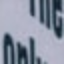

(32, 0, 64, 32)


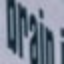

(64, 0, 96, 32)


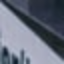



New Size
(0, 0, 64, 64)


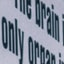

(64, 0, 128, 64)


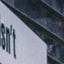

(128, 0, 192, 64)


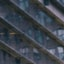



New Size
(0, 0, 96, 96)


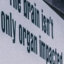

(96, 0, 192, 96)


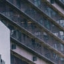

(192, 0, 288, 96)


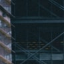



New Size
(0, 0, 128, 128)


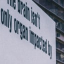

(128, 0, 256, 128)


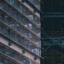

(256, 0, 384, 128)


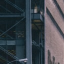

In [139]:
#SLIDING window implementation

start_roi_size = 64
multiplier = 0

cur_roi_size = start_roi_size*multiplier
fullrois = []
fulllocs = []
WIDTH = im_size[1] 
while cur_roi_size<=96:  
    multiplier+=0.5
    cur_roi_size = int(start_roi_size*multiplier)
    #WIDTH = 600 # 
    PYR_SCALE = 1.5
    WIN_STEP = int(64*multiplier) # running on laptop so I generated a small pyramid
    ROI_SIZE = (cur_roi_size, cur_roi_size)
    INPUT_SIZE = (64, 64) # input of resnet model.summary()
    (H, W) = tester.shape[:2] # 800, 600
    orig=tester

    pyramid = image_pyramid(tester, scale=PYR_SCALE, minSize=ROI_SIZE)
    # initialize two lists, one to hold the ROIs generated from the image pyramid 
    #and sliding window, and another list used to store the
    # (x, y)-coordinates of where the ROI was in the original image
    rois = []
    locs = []
    # time how long it takes to loop over the image pyramid layers and
    # sliding window locations
    start = time.time()
    counter = 0
    tot_images = 0
    for p, image in enumerate(pyramid):
        # determine the scale factor between the *original* image
        # dimensions and the *current* layer of the pyramid
        scale = W / float(image.shape[1])
        # for each layer of the image pyramid, loop over the sliding
        # window locations
        sw = 0
        for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
            sw = sw + 1
            # scale the (x, y)-coordinates of the ROI with respect to the
            # *original* image dimensions
            x = int(x * scale)
            y = int(y * scale)
            w = int(ROI_SIZE[0] * scale)
            h = int(ROI_SIZE[1] * scale)
            # take the ROI and pre-process it so we can later classify
            # the region using Keras/TensorFlow
            roi = cv2.resize(roiOrig, INPUT_SIZE)
            # update our list of ROIs and associated coordinates
            rois.append(roi)
            locs.append((x, y, x + w, y + h))
            # check to see if we are visualizing each of the sliding
            # windows in the image pyramid
            if args["visualize"] > 0:
                # clone the original image and then draw a bounding box
                # surrounding the current region
                clone = orig.copy()
                cv2.rectangle(clone, (x, y), (x + w, y + h),(0, 255, 0), 5)
                tot_images = tot_images +1
    print("Current window size: ",roiOrig.shape,"Which will be scaled to ", roi.shape)
   
    end = time.time()
    print("looping over windows took {:.5f} seconds".format(end - start))
    print("Total images {:.2f}".format(tot_images))
    fullrois.append(rois)
    fulllocs.append(locs)
    
    
for rois,locs in zip(fullrois,fulllocs):
    print('\n\nNew Size')
    for i in range(3):
        img=Image.fromarray(rois[i].astype('uint8'),'RGB')
        print(locs[i])
        display(img)


cur_test = []
cur_locs = []
for rois,locs in zip(fullrois,fulllocs):
    for i in range(len(rois)):
        temp = newreshape(rois[i])
        cur_test.append(temp)
        cur_locs.append(locs[i])

cur_test = np.array(cur_test)
cur_test = torch.from_numpy(cur_test)

In [140]:
#Normalizing the image segments before applying the models

cur_test = cur_test.type(torch.float32)
convert_tensor = transforms.ToTensor()
norm_cur_test = []


for trial in cur_test:
    mean, std = trial.mean([1,2]), trial.std([1,2])
    transform_norm = transforms.Compose([transforms.Normalize(mean, std)])

    # get normalized image
    try:
        img_n = transform_norm(trial)
    except:
        continue   
    norm_cur_test.append(img_n)

norm_cur_test = torch.stack(norm_cur_test)

#Applying the vehicle prediction model
preds = model(norm_cur_test)

In [141]:
predss = [1 if x>0.8 else 0 for x in preds]

indices_cars = []
for i in range(len(predss)):
    if predss[i] == 1:
        indices_cars.append(i)
print(indices_cars)

[1149, 1158, 1273, 1309, 1324, 1327, 1377, 1413, 1428, 1430, 1431, 1463, 1464, 1485]


In [144]:
#applying pedestrian detection model
preds_ped = modelped(norm_cur_test)

In [147]:
predss_ped = [1 if x>0.95 else 0 for x in preds_ped]

indices_peds = []
for i in range(len(predss_ped)):
    if predss_ped[i] == 1:
        indices_peds.append(i)
print(indices_peds)

[1086, 1097, 1098, 1099, 1101, 1102, 1112, 1113, 1124, 1127, 1136, 1209, 1210, 1212, 1213, 1214, 1230, 1231, 1234, 1236, 1243, 1244, 1252, 1253, 1254, 1259, 1262, 1290, 1291, 1292, 1296, 1300, 1301, 1304, 1306, 1322, 1323, 1334, 1340, 1347, 1348, 1349, 1353, 1354, 1356, 1357, 1358, 1363, 1366, 1379, 1394, 1395, 1396, 1397, 1400, 1404, 1405, 1408, 1410, 1417, 1426, 1427, 1437, 1438, 1444, 1447, 1448, 1449, 1450, 1453, 1455, 1456, 1457, 1458, 1461, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1481, 1482, 1483, 1488, 1495, 1496, 1497, 1498, 1499, 1500, 1501]


(192, 256, 256, 320) 0.9804869294166565


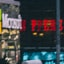

(768, 256, 832, 320) 0.9744086265563965


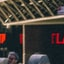

(672, 288, 768, 384) 0.9961745738983154


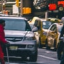

(144, 288, 288, 432) 0.8821115493774414


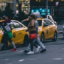

(0, 216, 216, 432) 0.8347932696342468


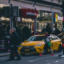

(648, 216, 864, 432) 0.9992062449455261


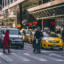

(672, 288, 768, 384) 0.9968852400779724


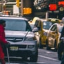

(144, 288, 288, 432) 0.8952081799507141


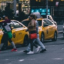

(0, 216, 216, 432) 0.8851467967033386


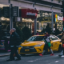

(432, 216, 648, 432) 0.8063216209411621


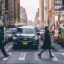

(648, 216, 864, 432) 0.9991829991340637


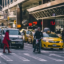

(640, 256, 768, 384) 0.9898444414138794


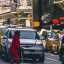

(768, 256, 896, 384) 0.8426054120063782


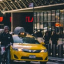

(192, 192, 384, 384) 0.9075731635093689


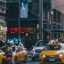

In [142]:
#image segments containing cars

cur_test = cur_test.type(torch.uint8)
for i in indices_cars:
    img=topil(cur_test[i])
    print(cur_locs[i], preds[i].item())
    display(img)
    


Output image with bounding boxes:


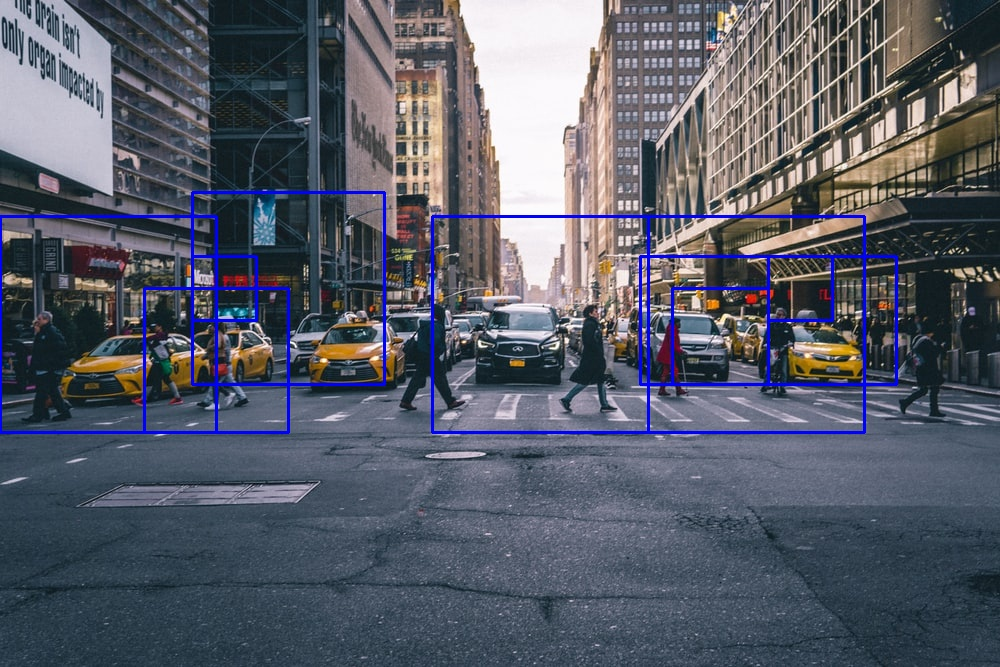

In [150]:
path = file_name
   
# Reading an image in default mode
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Blue color in BGR
color = (0, 0, 255)
# Line thickness of 2 px
thickness = 2
for i in indices_cars:  
    coods = cur_locs[i]
    # represents the top left corner of rectangle
    start_point = (coods[0], coods[1])
    # Ending coordinate, here (220, 220)
    # represents the bottom right corner of rectangle
    end_point = (coods[2], coods[3])
    # Using cv2.rectangle() method
    # Draw a rectangle with blue line borders of thickness of 2 px
    image = cv2.rectangle(image, start_point, end_point, color, thickness)
'''    
color = (255, 0, 0)    
for i in indices_peds:  
    coods = cur_locs[i]
    # Start coordinate, here (5, 5)
    # represents the top left corner of rectangle
    start_point = (coods[0], coods[1])
    # Ending coordinate, here (220, 220)
    # represents the bottom right corner of rectangle
    end_point = (coods[2], coods[3])
    # Using cv2.rectangle() method
    # Draw a rectangle with blue line borders of thickness of 2 px
    image = cv2.rectangle(image, start_point, end_point, color, thickness)
'''    
    
# Displaying the image 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.imwrite("output.jpg", image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

out_file_name = 'output.jpg'
topil = transforms.ToPILImage()
img = Image.open(out_file_name)
print("Output image with bounding boxes:")
display(img)